In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [ ]:

icu_data = pd.read_csv(r'Dataset\icu_data_simulated.csv')
x = icu_data.iloc[:, :-1]
y = icu_data.iloc[:, -1]
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_test = torch.Tensor(X_train.values), torch.Tensor(X_test.values)
y_train, y_test = torch.Tensor(y_train.values), torch.Tensor(y_test.values)


In [ ]:

# 3. Custom Dataset Class
class ICUTimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = ICUTimeSeriesDataset(X_train, y_train)
test_dataset = ICUTimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# 4. Define LSTM Model
class ICU_LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Add an extra dimension for sequence length using unsqueeze(1)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        # Adjust the index selection to account for the added dimension
        output = self.sigmoid(self.fc(lstm_out[:, -1, :]))
        return output

model = ICU_LSTM()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# 5. Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 20
for epoch in range(epochs):
    total_loss = 0
    model.train()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(" "*100,end="\r")
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}" , end="\r")


In [ ]:

# Save the trained model
torch.save(model.state_dict(), "icu_lstm_model.pth")


In [9]:



# 6. Evaluate the Model
model.eval()
y_preds = []
y_actual = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        y_preds.extend(outputs.cpu().numpy())
        y_actual.extend(targets.cpu().numpy())

y_preds = np.array(y_preds).flatten()
y_actual = np.array(y_actual)

# Convert probabilities to binary predictions
y_preds_binary = (y_preds >= 0.5).astype(int)


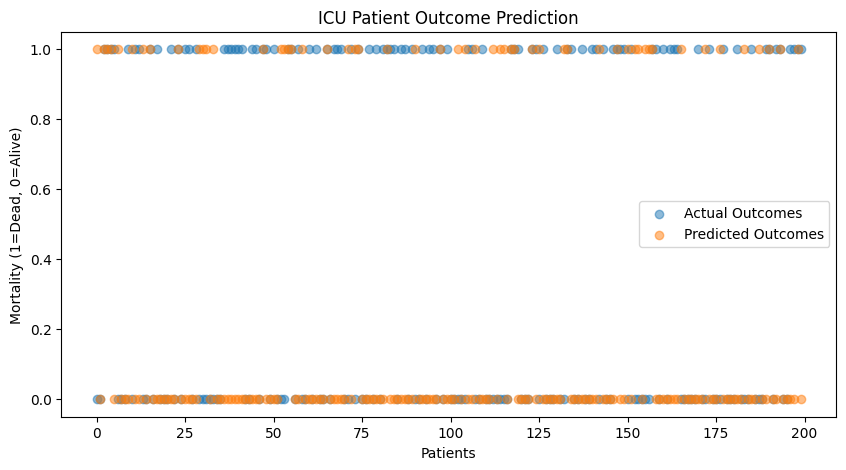

Test Accuracy: 49.00%


In [10]:

# Plot Predictions vs. Actual Outcomes
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_actual)), y_actual, label="Actual Outcomes",alpha=0.5)
plt.scatter(range(len(y_preds_binary)), y_preds_binary, label="Predicted Outcomes",alpha=0.5)

plt.legend()
plt.xlabel("Patients")
plt.ylabel("Mortality (1=Dead, 0=Alive)")
plt.title("ICU Patient Outcome Prediction")
plt.show()

# Evaluate Performance
accuracy = np.mean(y_preds_binary == y_actual)
print(f"Test Accuracy: {accuracy * 100:.2f}%")